<a href="https://colab.research.google.com/github/alistarv18/deepfake/blob/main/HF_audio_deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Off-the-shelf HuggingFace models for audio deepfake detection


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adrianastan/deepfake_pydata/blob/main/HF_audio_deepfake.ipynb)


## <font color="#e8710a">©Adriana STAN </font>

adrianac.stan@gmail.com | www.adrianastan.com

PyData Global - December 3rd, 2024




## Setup

In [1]:
import torch
import librosa
import os, sys
from tqdm import tqdm
import numpy as np
import seaborn as sns
from IPython.display import Audio
from transformers import AutoFeatureExtractor, WavLMModel, Wav2Vec2Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

import matplotlib.pylab as plt
from sklearn.manifold import TSNE

## Dataset download

We will use ASVSpoof 2019 dataset with its train and eval partitions:  https://zenodo.org/records/6906306

In [ ]:
 !wget -O LA.zip https://zenodo.org/records/6906306/files/LA.zip?download=1

--2025-03-17 18:44:47--  https://zenodo.org/records/6906306/files/LA.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7640952520 (7.1G) [application/octet-stream]
Saving to: ‘LA.zip’

LA.zip              100%[===================>]   7.12G  15.0MB/s    in 8m 24s  

2025-03-17 18:53:12 (14.4 MB/s) - ‘LA.zip’ saved [7640952520/7640952520]



In [ ]:
 !unzip LA.zip

Streaming output truncated to the last 5000 lines.
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7787040.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_2924301.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_9249366.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_3442936.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7772915.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_5569336.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7773607.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_7813281.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_9705954.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_2427464.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_1000273.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_5263550.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_1642109.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_1339848.flac  
  inflating: LA/ASVspoof2019_LA_eval/flac/LA_E_9495857.flac  
  inflating: LA/ASV

If you already have the data in your Drive, first connect to the Drive and the change the path to where your data is

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd "/content/drive/MyDrive/LA/"

/content/drive/MyDrive/LA


### Process the metadata



In [6]:
with open('/content/drive/MyDrive/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt') as fin:
  train_labels = {line.strip().split()[1]:1 if line.strip().split()[-1]=='spoof' else 0 for line in fin.readlines()}
  #în fișierul de protocol îi spunem modelului care sunt exemplele de voci reale (bona-fide) și care sunt deepfake-uri (spoof), astfel încât să poată învăța să facă diferența între ele.

In [7]:
with open('/content/drive/MyDrive/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt') as fin:
  eval_labels = {line.strip().split()[1]:1 if line.strip().split()[-1]=='spoof' else 0 for line in fin.readlines()}
  #verific daca modelul functioneaza bine

Listen to some audio samples

In [9]:
print(f"Label: {'spoof' if train_labels['LA_T_1786825']==1 else 'bonafide'}")
Audio('/content/drive/MyDrive/LA/ASVspoof2019_LA_train/flac/LA_T_1786825.flac')
#exemplu de a vedea secventele de antrenament

Label: bonafide


In [ ]:
print(f"Label: {'spoof' if train_labels['LA_T_1786825']==1 else 'bonafide'}")
Audio('/content/drive/MyDrive/LA/ASVspoof2019_LA_train/flac/LA_T_1786825.flac')


## Download and setup the HF models


Please make sure that you enable a GPU runtime

In [ ]:
class HuggingFaceFeatureExtractor:
    def __init__(self, model_class, name):
      #clasa modelului pe care il vom folosi si numele modelului pre-antrenat
        self.device = "cuda"
        #pentru a rula pe gpu
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(name)
        #extrage caracteristici audio si converteste pentru modelul nostru
        self.model = model_class.from_pretrained(name)
        self.model.eval()
        self.model.to(self.device)
        #se incarca modelul pre-antrenat si se seteaza in modul de evaluare(nu se ajusteaza ponderile)

    def __call__(self, audio, sr):
        inputs = self.feature_extractor(
        audio,
        sampling_rate=sr,
        return_tensors="pt",  # output-ul va fi un tensor PyTorch
        padding=True,
    )  # convertește semnalul audio într-un format compatibil cu modelul

    # Inițial, inputs este un dicționar cu tensori PyTorch
        inputs_on_device = {}  # Creăm un nou dicționar gol

        for key, value in inputs.items():  # Parcurgem fiecare cheie și valoare
          inputs_on_device[key] = value.to(self.device)  # Mutăm tensorul pe GPU sau CPU

        inputs = inputs_on_device  # Înlocuim vechiul dicționar cu cel nou

        with torch.no_grad():
          #Rulează modelul pe datele de intrare
          outputs = self.model(**inputs)
          #torch.no_grad() dezactivează calculul gradientului (pentru eficiență, deoarece nu antrenăm modelul).

        return outputs.last_hidden_state


In [ ]:
#FEATURE_EXTRACTORS = {
 #   "wav2vec2-base": lambda: HuggingFaceFeatureExtractor(
  #      Wav2Vec2Model, "facebook/wav2vec2-base"
   # ),
    #"wavlm-base": lambda: HuggingFaceFeatureExtractor(
     #   WavLMModel, "microsoft/wavlm-base"
    #)
#}

In [ ]:
model_wav2vec2 = HuggingFaceFeatureExtractor(Wav2Vec2Model, "facebook/wav2vec2-base")
#Variabila model_wav2vec2 conține modelul preantrenat facebook/wav2vec2-base, folosit pentru extragerea caracteristicilor audio.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [ ]:
model_wavlm =HuggingFaceFeatureExtractor(WavLMModel, "microsoft/wavlm-base")

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

## Feature extraction

### wav2vec2

In [10]:
indir = '/content/drive/MyDrive/LA/ASVspoof2019_LA_train/flac'
#calea catre fisierele audio

In [11]:
files = sorted(os.listdir(indir))
print ("Using %d files" %len(files))

wav2vec2_feats= np.zeros((len(files), 768))
#Conține vectori numerici (embedding-uri) extrași din fișierele audio folosind Wav2Vec2.

labels = np.zeros(len(files))
# Conține etichetele care indică dacă un fișier audio este real (0) sau deepfake (1)

for i, fi in enumerate(tqdm(files)):
  #tqdm(files) → înseamnă că afișează progresul procesării fișierelor din files.
    # read the audio and resample to 16kHz
    audio, sr = librosa.load(os.path.join(indir,fi), sr=16_000) #Încarcă fișierul audio și îl resamplează la 16kHz
    # run the inference

    feat = model_wav2vec2(audio, sr) #reprezentări numerice ale sunetului, folosite pentru sarcini de recunoaștere vocală (ASR - Automatic Speech Recognition) sau alte aplicații audio
    # average across time

    wav2vec2_feats[i] = np.mean(feat.squeeze().cpu().detach().numpy(), axis=0) #Transformă caracteristicile extrase de wav2vec2 într-un singur vector care reprezintă întreaga secvență audio.
    # Dacă feat are forma [1, T, D], după squeeze() devine [T, D]
    # Dacă feat este pe GPU (folosind PyTorch și CUDA), această operație îl mută pe CPU.
    # detach() este o funcție din PyTorch care rupe legătura tensorului de graful de calcul.
    # numpy() convertește un tensor PyTorch într-un array NumPy.
    # mean() calculează media elementelor dintr-un tensor.

    labels[i] = train_labels[os.path.splitext(fi)[0]]
    # os.path.splitext(fi)[0] → Elimină extensia ("fake1.wav" → "fake1").
    # Caută în train_labels → Ia valoarea (0 sau 1).
    # Salvează în labels[i] → Stochează eticheta în listă/dicționar.

np.save('wav2vec2_features.npy', {'X': wav2vec2_feats, 'y':labels, 'files':files})
# wav2vec2_feats = np.array([
#    [0.1, 0.2, 0.3, ..., 0.9],   # Feature-uri pentru fake1.wav
#    [0.5, 0.6, 0.7, ..., 1.2],   # Feature-uri pentru real1.wav
#    [0.2, 0.1, 0.9, ..., 0.4]    # Feature-uri pentru fake2.wav
#])

# labels = np.array([1, 0, 1])  # spoof = 1, bonafide = 0, spoof = 1
# files = np.array(['fake1.wav', 'real1.wav', 'fake2.wav'])


Using 25380 files


  0%|          | 0/25380 [00:03<?, ?it/s]


KeyboardInterrupt: 

### wavLM

In [ ]:
#files = [k for k in sorted(os.listdir(indir))]
print ("Using %d files" %len(files))
wavlm_feats= np.zeros((len(files), 768))

for i, fi in enumerate(tqdm(files)):
    # read the audio and resample to 16kHz
    audio, sr = librosa.load(f"{indir}/{fi}", sr=16_000)
    #indir = "/home/user/audio"       fi = "sunet.wav"-----> merge la cele 2

    # run the inference
    feat = model_wavlm(audio, sr)
    # average across time

    wavlm_feats[i] = np.mean(feat.squeeze().cpu().detach().numpy(), axis=0)

np.save('wavlm_features.npy', {'X': wavlm_feats, 'y':labels, 'files':files})

Using 25380 files


  0%|          | 0/25380 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 25380/25380 [10:59<00:00, 38.49it/s]


## Setup the data and classifier



### wav2vec2 results

In [ ]:
## Load the data
data = np.load('/content/wav2vec2_features.npy', allow_pickle=True).item()
X = data['X']
y = data['y']


I already have the features extracted with the 2 models, so I will just load them

In [ ]:
#data_train = np.load('data/asvspoof19-train-wav2vec2-base-all.h5.npz')
#X_train = data_train['X']
#y_train = data_train['y']

data_test = np.load('data/asvspoof19-eval-wav2vec2-base-all.h5.npz')
X_test = data_test['X']
y_test = data_test['y']

ValueError: Object arrays cannot be loaded when allow_pickle=False

Look at the data

In [ ]:
print(f"TRAIN set: Number of fake samples: {np.where(y_train==1)[0].shape[0]} | Number of real samples: {np.where(y_train==0)[0].shape[0]}")

TRAIN set: Number of fake samples: 22800 | Number of real samples: 2580


In [ ]:
print(f"TEST set: Number of fake samples: {np.where(y_test==1)[0].shape[0]} | Number of real samples: {np.where(y_test==0)[0].shape[0]}")

TEST set: Number of fake samples: 63882 | Number of real samples: 7355


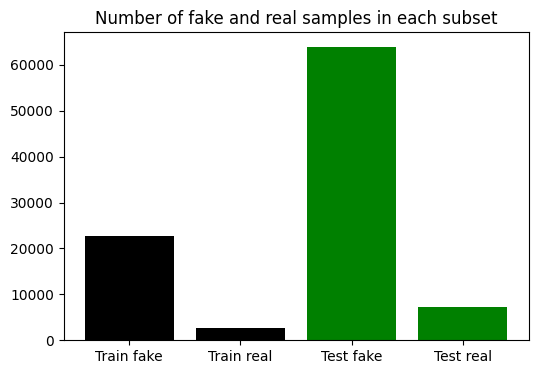

In [ ]:
plt.figure(figsize=(6,4))
plt.bar([0,1], [np.where(y_train==1)[0].shape[0], np.where(y_train==0)[0].shape[0]], color='black')
plt.bar([2,3], [np.where(y_test==1)[0].shape[0], np.where(y_test==0)[0].shape[0]], color = 'green')
plt.title("Number of fake and real samples in each subset")
plt.xticks([0,1,2,3],['Train fake', 'Train real', 'Test fake', 'Test real']);

Let see some samples projected into 2D space

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20)
# take just a subset of samples
X_embb_train = tsne.fit_transform(X_train[::10])

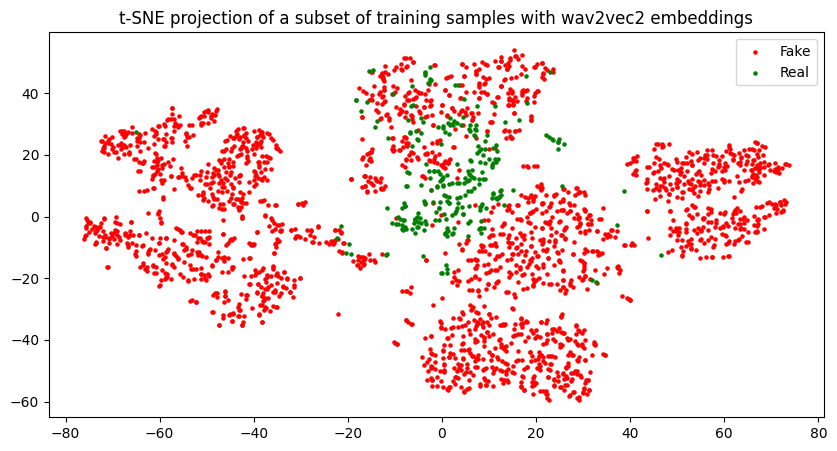

In [ ]:
ytsne = y_train[::10] # take just a subset of samples
fake_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==1]
real_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==0]

plt.figure(figsize=(10,5))
plt.title("t-SNE projection of a subset of training samples with wav2vec2 embeddings")
plt.scatter(X_embb_train[fake_indices,0], X_embb_train[fake_indices,1], color='r', s=5)
plt.scatter(X_embb_train[real_indices,0], X_embb_train[real_indices,1], color='g', s=5)
plt.legend(["Fake", 'Real']);

Same for the test set

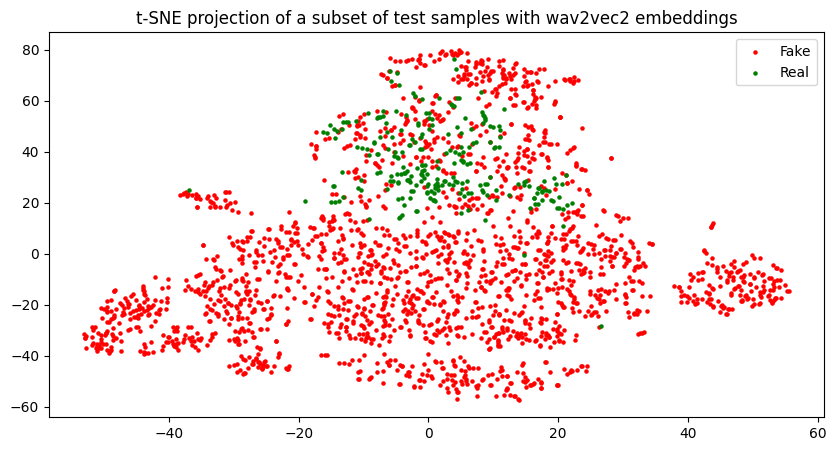

In [ ]:
X_embb_test = tsne.fit_transform(X_test[::30])
ytsne = y_test[::30]
fake_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==1]
real_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==0]

plt.figure(figsize=(10,5))
plt.title("t-SNE projection of a subset of test samples with wav2vec2 embeddings")
plt.scatter(X_embb_test[fake_indices,0], X_embb_test[fake_indices,1], color='r', s=5)
plt.scatter(X_embb_test[real_indices,0], X_embb_test[real_indices,1], color='g', s=5)
plt.legend(["Fake", 'Real']);

#### Fit the classifier

You can choose others as well... [Scikit Classifiers](https://scikit-learn.org/stable/supervised_learning.html)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

Predict....

First on the training data

In [ ]:
y_hat_train = clf.predict(X_train)

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      2580
         1.0       0.99      1.00      1.00     22800

    accuracy                           0.99     25380
   macro avg       0.99      0.98      0.98     25380
weighted avg       0.99      0.99      0.99     25380



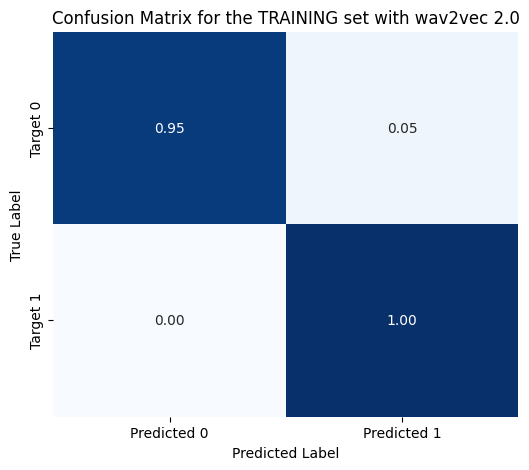

In [ ]:
print(classification_report(y_train, y_hat_train))
cm = confusion_matrix(y_train, y_hat_train, normalize='true')


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Target 0', 'Target 1'])
plt.title("Confusion Matrix for the TRAINING set with wav2vec 2.0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label");

And on the test data

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      7355
         1.0       0.99      0.98      0.98     63882

    accuracy                           0.97     71237
   macro avg       0.92      0.93      0.92     71237
weighted avg       0.97      0.97      0.97     71237



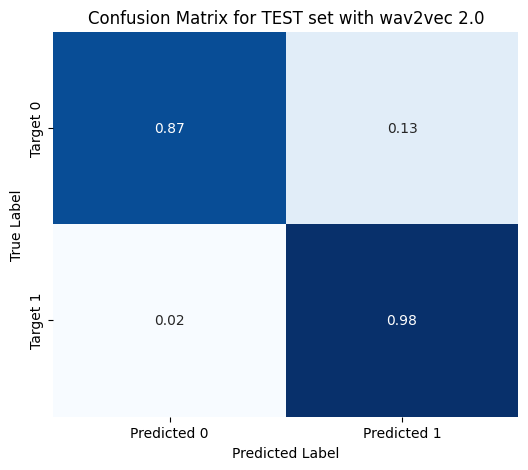

In [ ]:
y_hat_test = clf.predict(X_test)
print(classification_report(y_test, y_hat_test))
cm = confusion_matrix(y_test, y_hat_test, normalize='true')


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Target 0', 'Target 1'])
plt.title("Confusion Matrix for TEST set with wav2vec 2.0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label");

We can also compute the **Equal Error Rate** = the point where the False Acceptance Rate (FAR) equals the False Rejection Rate (FRR)

In [ ]:
y_hat_train_proba=clf.predict_proba(X_train)

fpr, tpr, thresholds = roc_curve(y_train, y_hat_train_proba[:,1], pos_label=1)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print ("Training set EER: ", np.round(eer*100,2), "| Threshold: ", np.round(thresh,3))

Training set EER:  1.24 | Threshold:  0.795


In [ ]:
y_hat_test_proba=clf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_proba[:,1], pos_label=1)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print ("Test set EER: ", np.round(eer*100,2), "| Threshold: ", np.round(thresh,3))

Test set EER:  5.28 | Threshold:  0.775


### wavLM results

In [ ]:
# train data
data_train = np.load('data/asvspoof19-train-wavlm-base-all.h5.npz')
X_train = data_train['X']
y_train = data_train['y']

# test data
data_test = np.load('data/asvspoof19-eval-wavlm-base-all.h5.npz')
X_test = data_test['X']
y_test = data_test['y']

t-SNE for wavLM embeddings

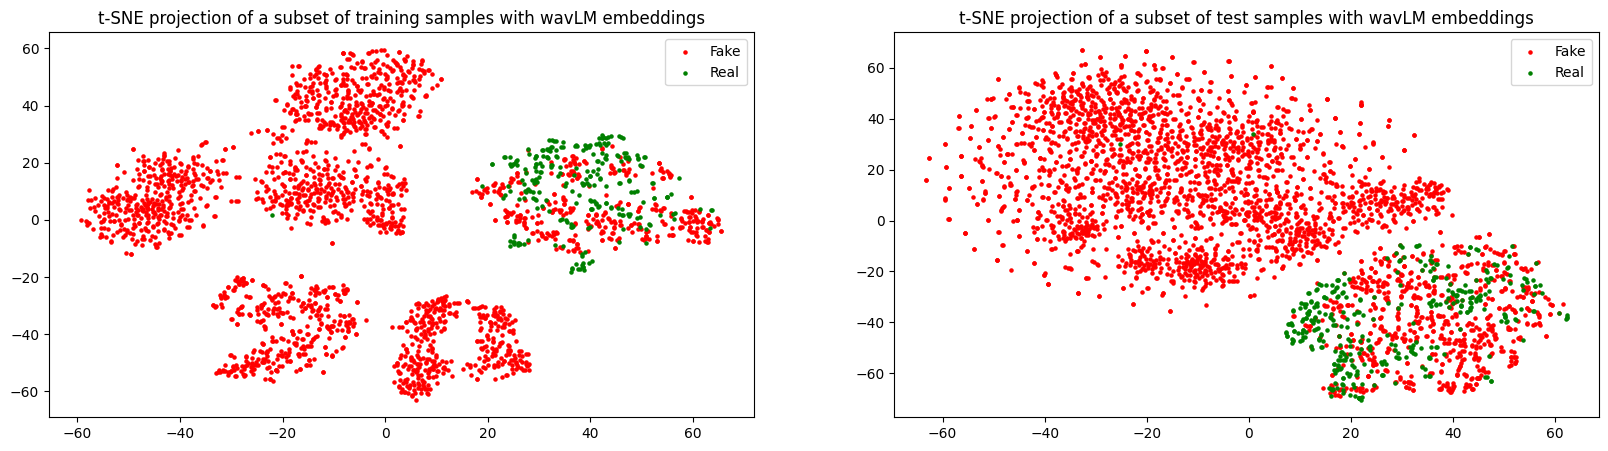

In [ ]:
X_embb = tsne.fit_transform(X_train[::10])

ytsne = y_train[::10]
fake_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==1]
real_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==0]

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("t-SNE projection of a subset of training samples with wavLM embeddings")
plt.scatter(X_embb[fake_indices,0], X_embb[fake_indices,1], color='r', s=5)
plt.scatter(X_embb[real_indices,0], X_embb[real_indices,1], color='g', s=5)
plt.legend(["Fake", 'Real']);


X_embb = tsne.fit_transform(X_test[::20])
ytsne = y_test[::20]
fake_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==1]
real_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==0]

plt.subplot(122)
plt.title("t-SNE projection of a subset of test samples with wavLM embeddings")
plt.scatter(X_embb[fake_indices,0], X_embb[fake_indices,1], color='r', s=5)
plt.scatter(X_embb[real_indices,0], X_embb[real_indices,1], color='g', s=5)
plt.legend(["Fake", 'Real']);

#### Fit the classifier

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

Training set results
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      2580
         1.0       1.00      1.00      1.00     22800

    accuracy                           0.99     25380
   macro avg       0.99      0.98      0.98     25380
weighted avg       0.99      0.99      0.99     25380


Training set EER:  1.05 | Threshold:  0.781


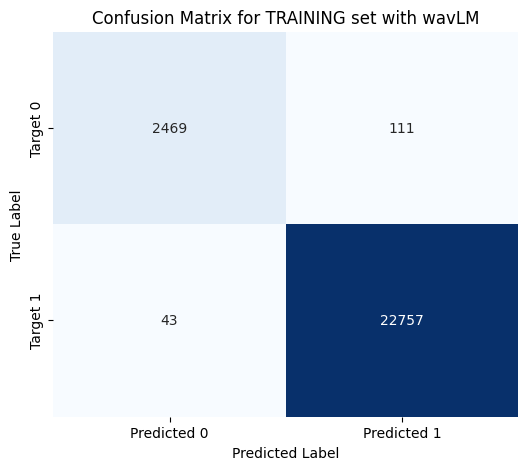

In [ ]:
## Predict on train
print("Training set results")
y_hat_train = clf.predict(X_train)
print(classification_report(y_train, y_hat_train))
cm = confusion_matrix(y_train, y_hat_train)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Target 0', 'Target 1'])
plt.title("Confusion Matrix for TRAINING set with wavLM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

## EER
y_hat_train_proba=clf.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_hat_train_proba[:,1], pos_label=1)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print ("\nTraining set EER: ", np.round(eer*100,2), "| Threshold: ", np.round(thresh,3))


Test set results
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      7355
         1.0       0.98      0.98      0.98     63882

    accuracy                           0.96     71237
   macro avg       0.89      0.91      0.90     71237
weighted avg       0.96      0.96      0.96     71237


Test set EER:  5.66 | Threshold:  0.843


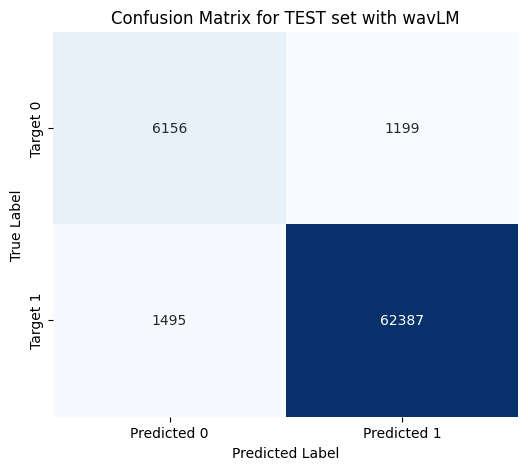

In [ ]:
## Predict on test
print("Test set results")
y_hat_test = clf.predict(X_test)
print(classification_report(y_test, y_hat_test))
cm =confusion_matrix(y_test, y_hat_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Target 0', 'Target 1'])
plt.title("Confusion Matrix for TEST set with wavLM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

## EER
y_hat_test_proba=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_proba[:,1], pos_label=1)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print ("\nTest set EER: ", np.round(eer*100,2), "| Threshold: ", np.round(thresh,3))

## Finally run the model on your audio samples

In [ ]:
# FILE_PATH = 'data/T_0000000010.flac' # fake
#FILE_PATH = 'data/T_0000000011.flac' #real
FILE_PATH = 'data/T_0000000019.flac' #fake

audio, sr = librosa.load(FILE_PATH, sr=16_000)
embedding = model_wav2vec2(audio, sr)
feat = np.mean(embedding.squeeze().cpu().detach().numpy(), axis=0)

y_hat = clf.predict(feat.reshape(1, -1))
y_hat_proba = clf.predict_proba(feat.reshape(1, -1))
print(f"Your sample is {'FAKE' if y_hat==1 else 'REAL'} with a probability of {(y_hat_proba[0][1] if y_hat==1 else y_hat_proba[0][0]):.2f}")

Your sample is FAKE with a probability of 0.96


In [ ]:
Audio('data/T_0000000019.flac')

## What next?



*   generalisation (OOD)
*   new systems = continual learning
*   model attribution
*   ...


